<a href="https://colab.research.google.com/github/bilzard/JQuants-news/blob/main/001-eda-stock-price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに

このnotebookでは2020年までの株式のデータに着目した初歩的なEDAについて記述します。

In [ ]:
%%HTML
<style>
    div#notebook-container    { width: 100%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [ ]:
# Google Colab環境ではGoogle Driveをマウントしてアクセスできるようにします。
import sys

if 'google.colab' in sys.modules:
    # Google Drive をマウントします
    from google.colab import drive
    mount_dir = "/content/drive"
    drive.mount(mount_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ライブラリのバージョンを調整します
!pip install --no-cache-dir joblib==1.0.1 numpy==1.19.5 pandas==1.1.5 scikit-learn==0.20.3 scipy==1.2.1 seaborn==0.9.0

     |████████████████████████████████| 24.8MB 1.4MB/s 
     |████████████████████████████████| 215kB 43.0MB/s 
ERROR: phik 0.11.2 has requirement scipy>=1.5.2, but you'll have scipy 1.2.1 which is incompatible.
ERROR: pandas-profiling 2.11.0 has requirement scipy>=1.4.1, but you'll have scipy 1.2.1 which is incompatible.
ERROR: pandas-profiling 2.11.0 has requirement seaborn>=0.10.1, but you'll have seaborn 0.9.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.6.2
    Uninstalling scipy-1.6.2:
      Successfully uninstalled scipy-1.6.2
  Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1


In [ ]:
import io
import os
import sys
import zipfile

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from scipy import stats
from IPython.core.magic import register_cell_magic

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


作業ディレクトリを指定します。自分の環境に合わせて適宜設定してください。

In [ ]:
PROJECT_DIR = f'{mount_dir}/MyDrive/JPX_competition/sub001'

In [ ]:
# インポート時にエラーが出た場合は、以下のmodule_dirをbacktest.pyを配置したディレクトリに変更してください。
import sys
if 'google.colab' in sys.modules:
  # Backtestを配置したディレクトリへのフルパスを指定します
  module_dir = f"{mount_dir}/MyDrive/JPX_competition/Chapter03/backtest"
else:
  # Backtestを配置したディレクトリへのフルパスを指定します
  module_dir = "/notebook/Chapter03/backtest" 
sys.path.append(module_dir)

from backtest import Backtest

In [ ]:
# 表示用の設定を変更します
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [ ]:
# データセットを配置したディレクトリのパスを設定
if 'google.colab' in sys.modules:
    dataset_dir = f"{mount_dir}/MyDrive/JPX_competition/data_dir_comp2"
else:
    dataset_dir = "/notebook/data_dir_comp2"

In [ ]:
# 入力パラメーターを設定します。ランタイム環境での実行時と同一フォーマットにします
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
}

In [ ]:
# 投資対象日付を指定します
start_dt = pd.Timestamp("2020-01-01")

In [ ]:
if "purchase_date" in inputs.keys():
    # ランタイム環境では指定された投資対象日付を使用します
    # purchase_dateを読み込み
    df_purchase_date = pd.read_csv(inputs["purchase_date"])
    # purchase_dateの最も古い日付を投資対象日付として使用します
    start_dt = pd.Timestamp(df_purchase_date.sort_values("Purchase Date").iloc[0, 0])

In [ ]:
# 銘柄情報読み込み
df_stock_list = pd.read_csv(inputs["stock_list"])
# 問題2のユニバース (投資対象の条件を満たす銘柄群) 取得
codes = df_stock_list.loc[
    df_stock_list.loc[:, "universe_comp2"] == True, "Local Code"
].unique()

In [ ]:
# 価格情報読み込み、インデックス作成
df_price = pd.read_csv(inputs["stock_price"]).set_index("EndOfDayQuote Date")
# 日付型に変換
df_price.index = pd.to_datetime(df_price.index, format="%Y-%m-%d")

In [ ]:
df_price

,Local Code,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP
EndOfDayQuote Date,,,,,,,,,,,,,,,
2016-01-04,1301,2800.0,2820.0,2740.0,2750.0,2750.0,32000.0,0.1,2770.0,2015/12/30,2770.0,2015/12/30,-20.0,-0.722,2778.250
2016-01-05,1301,2750.0,2780.0,2750.0,2760.0,2760.0,20100.0,0.1,2750.0,2016/01/04,2750.0,2016/01/04,10.0,0.364,2761.990
2016-01-06,1301,2760.0,2770.0,2740.0,2760.0,2760.0,15000.0,0.1,2760.0,2016/01/05,2760.0,2016/01/05,0.0,0.000,2758.867
2016-01-07,1301,2740.0,2760.0,2710.0,2710.0,2710.0,31400.0,0.1,2760.0,2016/01/06,2760.0,2016/01/06,-50.0,-1.812,2733.471
2016-01-08,1301,2700.0,2740.0,2690.0,2700.0,2700.0,26200.0,0.1,2710.0,2016/01/07,2710.0,2016/01/07,-10.0,-0.369,2709.122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,9997,995.0,1037.0,995.0,1025.0,1025.0,332300.0,1.0,980.0,2020/12/23,980.0,2020/12/23,45.0,4.592,1022.925
2020-12-25,9997,1018.0,1072.0,1018.0,1065.0,1065.0,426200.0,1.0,1025.0,2020/12/24,1025.0,2020/12/24,40.0,3.902,1048.806
2020-12-28,9997,1080.0,1096.0,1050.0,1072.0,1072.0,391400.0,1.0,1065.0,2020/12/25,1065.0,2020/12/25,7.0,0.657,1073.684


In [ ]:
! pip install -U pandas-profiling

Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.7/dist-packages (2.11.0)
  Using cached https://files.pythonhosted.org/packages/75/91/ee427c42957f8c4cbe477bf4f8b7f608e003a17941e509d1777e58648cb3/scipy-1.6.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/68/ad/6c2406ae175f59ec616714e408979b674fe27b9587f79d59a528ddfbcd5b/seaborn-0.11.1-py3-none-any.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.2.1
    Uninstalling scipy-1.2.1:
      Successfully uninstalled scipy-1.2.1
  Found existing installation: seaborn 0.9.0
    Uninstalling seaborn-0.9.0:
      Successfully uninstalled seaborn-0.9.0


In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df_price)

一般的なEDAのレポートを作成します。htmlファイルがPROJECT_DIR配下に出力されるので、ブラウザなどで開いてください。
なお、データが多いので処理には数分かかります。

In [ ]:
#profile.to_file(os.path.join(PROJECT_DIR, 'profile_stock_price.html'))

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# 投資対象日の前週金曜日時点で予測を出力するため、予測出力用の日付を設定します。
pred_start_dt = pd.Timestamp(start_dt) - pd.Timedelta("3D")
# 特徴量の生成に必要な日数をバッファとして設定
n = 30
# データ絞り込み日付設定
data_start_dt = pred_start_dt - pd.offsets.BDay(n)
# 日付で絞り込み
filter_date = df_price.index >= data_start_dt
# 銘柄をユニバースで絞り込み
filter_universe = df_price.loc[:, "Local Code"].isin(codes)
# 絞り込み実施
df_price = df_price.loc[filter_date & filter_universe]

In [ ]:
df_price.head(3).T

EndOfDayQuote Date,2019-11-18,2019-11-19,2019-11-20
Local Code,1301,1301,1301
EndOfDayQuote Open,2941,2930,2939
EndOfDayQuote High,2941,2948,2939
EndOfDayQuote Low,2923,2926,2883
EndOfDayQuote Close,2935,2938,2895
EndOfDayQuote ExchangeOfficialClose,2935,2938,2895
EndOfDayQuote Volume,14200,12800,35700
EndOfDayQuote CumulativeAdjustmentFactor,1,1,1
EndOfDayQuote PreviousClose,2923,2935,2938
EndOfDayQuote PreviousCloseDate,2019/11/15,2019/11/18,2019/11/19


直感的に理解しやすい日付 x 銘柄のテーブルを作ります。

In [ ]:
df_per_instruments = pd.pivot_table(df_price, values=['EndOfDayQuote Close'], columns=['Local Code'], index='EndOfDayQuote Date', aggfunc='mean')

In [ ]:
df_per_instruments

EndOfDayQuote Close                                                                                 \
Local Code                        1301   1332    1333    1375    1377    1379    1407    1413    1414    1417    1419   
EndOfDayQuote Date                                                                                                      
2019-11-18                      2935.0  653.0  2915.0     NaN  3665.0  1923.0  1113.8  2235.0  4330.0  1722.0  1970.0   
2019-11-19                      2938.0  641.0  2924.0     NaN  3670.0  1933.0  1137.7  2225.0  4265.0  1712.0  1995.0   
2019-11-20                      2895.0  618.0  2924.0     NaN  3625.0  1937.0  1136.9  2220.0  4275.0  1706.0  2010.0   
2019-11-21                      2902.0  612.0  2897.0     NaN  3670.0  1953.0  1131.5  2225.0  4325.0  1728.0  1955.0   
2019-11-22                      2893.0  615.0  2863.0     NaN  3620.0  1957.0  1153.8  2242.0  4275.0  1719.0  1965.0   
...                                ...    ...     ...     ...     ...     ...     ...     ...     ...     ...     ...   
2020-12-24                      2917.0  420.0  2178.0  1722.0  3555.0  2107.0  4630.0  2181.0  5010.0  1679.0  1446.0   
2020-12-25                      2916.0  423.0  2189.0  1716.0  3595.0  2112.0  4850.0  2200.0  5040.0  1697.0  1447.0   
2020-12-28                      2950.0  420.0  2206.0  1690.0  3615.0  2095.0  4770.0  2225.0  5030.0  1713.0  1438.0   
2020-12-29                      2961.0  428.0  2236.0  1705.0  3625.0  2107.0  4805.0  2184.0  5060.0  1746.0  1451.0   
2020-12-30                      2951.0  426.0  2220.0  1693.0  3575.0  2087.0  4745.0  2164.0  5010.0  1768.0  1472.0   

                                                                                                                       \
Local Code           1429    1431   1448    1515    1605    1662    1663   1719   1720    1721    1723   1726    1762   
EndOfDayQuote Date                                                                                                      
2019-11-18          757.0   925.0  518.0  4615.0  1033.5  2934.0  1624.0  956.0  828.0  3205.0  3100.0  467.0  2674.0   
2019-11-19          742.0   898.8  517.0  4630.0  1020.5  2903.0  1615.0  948.0  823.0  3205.0  2992.0  470.0  2693.0   
2019-11-20          756.0   868.8  516.0  4570.0  1009.0  2834.0  1567.0  936.0  810.0  3255.0  3005.0  474.0  2711.0   
2019-11-21          758.0   902.5  516.0  4515.0  1012.0  2792.0  1594.0  916.0  796.0  3250.0  3010.0  479.0  2740.0   
2019-11-22          743.0   932.5  517.0  4515.0  1019.5  2831.0  1573.0  908.0  778.0  3275.0  3055.0  479.0  2750.0   
...                   ...     ...    ...     ...     ...     ...     ...    ...    ...     ...     ...    ...     ...   
2020-12-24          653.0  2025.0  639.0  6140.0   573.0  1905.0  1440.0  706.0  499.0  3095.0  3790.0  644.0  2027.0   
2020-12-25          655.0  1998.0  644.0  6310.0   578.0  1914.0  1453.0  709.0  498.0  3105.0  3755.0  655.0  2030.0   
2020-12-28          648.0  1995.0  690.0  6160.0   573.0  1888.0  1453.0  707.0  493.0  3080.0  3760.0  640.0  2042.0   
2020-12-29          650.0  2007.0  687.0  6080.0   562.0  1904.0  1490.0  724.0  497.0  3195.0  3810.0  642.0  2071.0   
2020-12-30          649.0  2008.0  697.0  6130.0   556.0  1876.0  1490.0  720.0  495.0  3205.0  3805.0  643.0  2045.0   

                                                                                                                   \
Local Code            1766    1793    1799    1801    1802    1803    1805    1808   1810    1811    1812    1813   
EndOfDayQuote Date                                                                                                  
2019-11-18          7260.0  4880.0  1621.0  4230.0  1167.0  1082.0  1450.0  1437.0  823.0  4065.0  1450.0  1546.0   
2019-11-19          7250.0  4880.0  1621.0  4175.0  1179.0  1078.0  1426.0  1422.0  801.0  4035.0  1428.0  1549.0   
2019-11-20          7200.0  5250.0  1630.0  

In [ ]:
df_per_instruments.columns = df_per_instruments.columns.droplevel(level=0)

In [ ]:
df_per_instruments

Local Code,1301,1332,1333,1375,1377,1379,1407,1413,1414,1417,1419,1429,1431,1448,1515,1605,1662,1663,1719,1720,1721,1723,1726,1762,1766,1793,1799,1801,1802,1803,1805,1808,1810,1811,1812,1813,1815,1820,1821,1822,1824,1833,1835,1852,1860,1861,1870,1871,1878,1879,...,9757,9759,9766,9783,9787,9788,9790,9793,9795,9810,9823,9824,9828,9830,9831,9832,9842,9843,9850,9856,9861,9869,9873,9882,9887,9889,9896,9900,9902,9903,9919,9928,9932,9934,9936,9945,9946,9948,9956,9960,9962,9974,9979,9983,9984,9987,9989,9991,9994,9997
EndOfDayQuote Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-18,2935.0,653.0,2915.0,NaN,3665.0,1923.0,1113.8,2235.0,4330.0,1722.0,1970.0,757.0,925.0,518.0,4615.0,1033.5,2934.0,1624.0,956.0,828.0,3205.0,3100.0,467.0,2674.0,7260.0,4880.0,1621.0,4230.0,1167.0,1082.0,1450.0,1437.0,823.0,4065.0,1450.0,1546.0,2952.0,2377.0,596.0,3035.0,1007.0,2959.0,3320.0,4455.0,691.0,3255.0,781.0,716.0,13570.0,968.0,...,2637.0,1765.0,4840.0,2967.0,3845.0,1066.0,3720.0,3195.0,1498.0,5000.0,1801.0,2873.0,3105.0,2765.0,573.0,1802.0,1311.0,16805.0,1185.0,946.0,2710.0,3765.0,2627.0,1884.0,4155.0,1809.0,629.0,1384.0,2113.0,1719.0,1057.0,3025.0,2024.0,2560.0,6600.0,1900.0,1489.0,2346.0,2013.0,2460.0,2810.0,5120.0,1601.0,67860.0,4330.0,5140.0,3805.0,948.0,2240.0,730.0
2019-11-19,2938.0,641.0,2924.0,NaN,3670.0,1933.0,1137.7,2225.0,4265.0,1712.0,1995.0,742.0,898.8,517.0,4630.0,1020.5,2903.0,1615.0,948.0,823.0,3205.0,2992.0,470.0,2693.0,7250.0,4880.0,1621.0,4175.0,1179.0,1078.0,1426.0,1422.0,801.0,4035.0,1428.0,1549.0,2966.0,2411.0,596.0,3030.0,983.0,2947.0,3300.0,4445.0,680.0,3290.0,767.0,706.0,13685.0,975.0,...,2591.0,1792.5,4820.0,2970.0,3855.0,1077.0,3750.0,3200.0,1495.0,5020.0,1800.0,2922.0,3130.0,2759.0,562.0,1799.0,1305.0,16820.0,1188.0,945.0,2736.0,3775.0,2644.0,1885.0,4190.0,1806.0,641.0,1382.0,2122.0,1711.0,1060.0,3045.0,2026.0,2560.0,6580.0,1904.0,1495.0,2341.0,2012.0,2459.0,2729.0,5140.0,1608.0,66920.0,4272.0,5130.0,3830.0,935.0,2247.0,731.0
2019-11-20,2895.0,618.0,2924.0,NaN,3625.0,1937.0,1136.9,2220.0,4275.0,1706.0,2010.0,756.0,868.8,516.0,4570.0,1009.0,2834.0,1567.0,936.0,810.0,3255.0,3005.0,474.0,2711.0,7200.0,5250.0,1630.0,4130.0,1170.0,1057.0,1401.0,1393.0,786.0,4025.0,1438.0,1524.0,2906.0,2365.0,596.0,2960.0,970.0,2958.0,3285.0,4375.0,672.0,3235.0,764.0,694.0,13620.0,926.0,...,2562.0,1800.0,4880.0,2957.0,3875.0,1064.0,3675.0,3210.0,1504.0,4990.0,1800.0,2924.0,3135.0,2772.0,556.0,1806.0,1281.0,17090.0,1183.0,917.0,2756.0,3695.0,2653.0,1872.0,4180.0,1751.0,640.0,1374.0,2047.0,1727.0,1054.0,3060.0,2025.0,2555.0,6570.0,1909.0,1484.0,2342.0,2052.0,2457.0,2722.0,5100.0,1601.0,66090.0,4220.0,5100.0,3855.0,936.0,2203.0,717.0
2019-11-21,2902.0,612.0,2897.0,NaN,3670.0,1953.0,1131.5,2225.0,4325.0,1728.0,1955.0,758.0,902.5,516.0,4515.0,1012.0,2792.0,1594.0,916.0,796.0,3250.0,3010.0,479.0,2740.0,7230.0,5020.0,1630.0,4165.0,1173.0,1075.0,1392.0,1401.0,787.0,3970.0,1447.0,1524.0,2907.0,2367.0,598.0,2947.0,972.0,3005.0,3300.0,4405.0,676.0,3255.0,771.0,694.0,13600.0,914.0,...,2595.0,1815.0,4750.0,2936.0,3870.0,1071.0,3790.0,3240.0,1496.0,4995.0,1787.0,2906.0,3105.0,2761.0,566.0,1810.0,1280.0,16960.0,1190.0,930.0,2789.0,3705.0,2714.0,1885.0,4215.0,1765.0,637.0,1384.0,2045.0,1729.0,1054.0,3150.0,2032.0,2565.0,6590.0,1925.0,1479.0,2341.0,2055.0,2458.0,2694.0,5100.0,1618.0,66230.0,4152.0,5000.0,3825.0,943.0,2178.0,714.0
2019-11-22,2893.0,615.0,2863.0,NaN,3620.0,1957.0,1153.8,2242.0,4275.0,1719.0,1965.0,743.0,932.5,517.0,4515.0,1019.5,2831.0,1573.0,908.0,778.0,3275.0,3055.0,479.0,2750.0,7200.0,5040.0,1630.0,4230.0,1175.0,1078.0,1392.0,1394.0,778.0,3970.0,1432.0,1520.0,2916.0,2362.0,598.0,2950.0,968.0,3000.0,3280.0,4425.0,674.0,3225.0,768.0,685.0,13480.0,924.0,...,2569.0,1812.5,4835.0,2954.0,3895.0,1068.0,3795.0,3220.0,1524.0,5010.0,1785.0,2888.0,3065.0,2766.0,563.0,1810.0,1271.0,16990.0,1181.0,927.0,2787.0,3720.0,2790.0,1941.0,4235.0,1870.0,642.0,1381.0,2073.0,1743.0,1058.0,3210.0,2017.0,25

# 欠損値の可視化

銘柄ごとにどの程度欠損値を含むかを可視化します

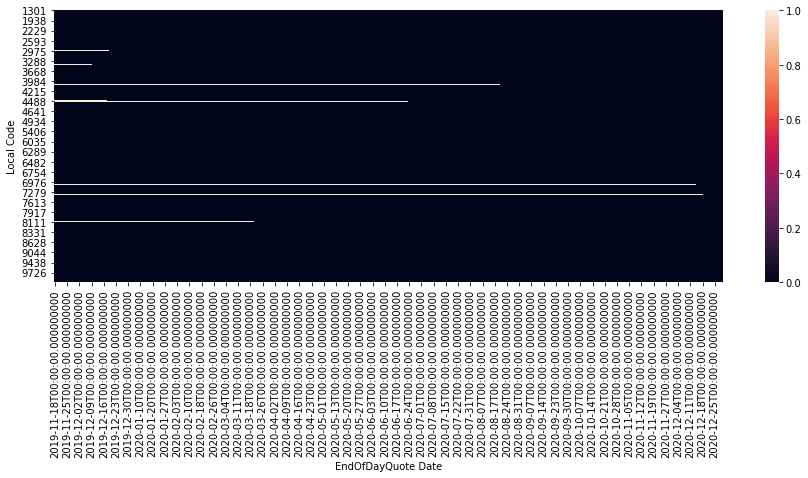

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.heatmap(df_per_instruments.isna().T, ax=ax)

銘柄をピックアップして時系列をプロットします

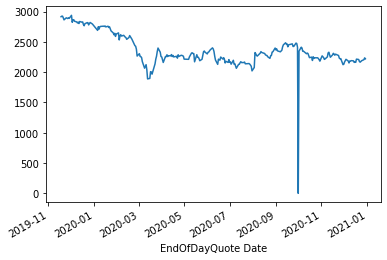

In [ ]:
df_per_instruments.iloc[:, 2].plot()

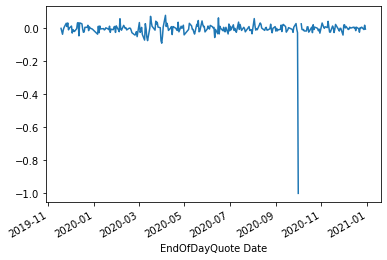

In [ ]:
df_per_instruments.iloc[:, 1].pct_change(1).fillna(0).plot()

# 異常値の除外

なぜか 2020-10-01 のデータがすべてゼロになっているので、このレコードを除外します。（おそらくランタイム環境でも外れ値を除外する処理が必要になる）

In [ ]:
# 外れ値（終値が0以下）を除外
filter_outlier = df_per_instruments.iloc[:, 0] > 0
df_per_instruments = df_per_instruments[filter_outlier]

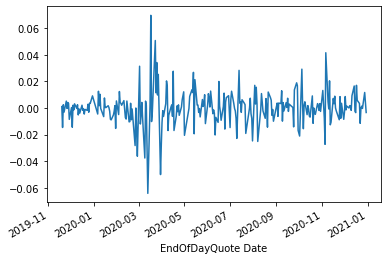

In [ ]:
df_per_instruments.iloc[:, 0].pct_change(1).plot()

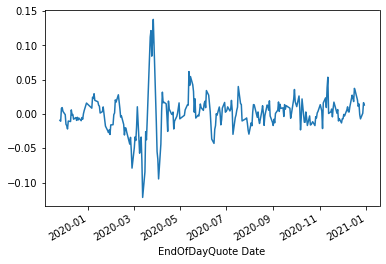

In [ ]:
df_per_instruments.iloc[:, 0].pct_change(5).plot()

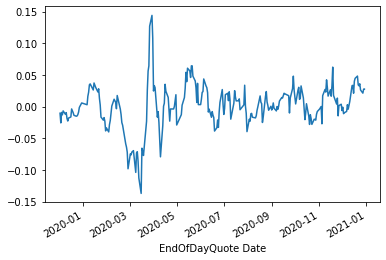

In [ ]:
df_per_instruments.iloc[:, 0].pct_change(10).plot()

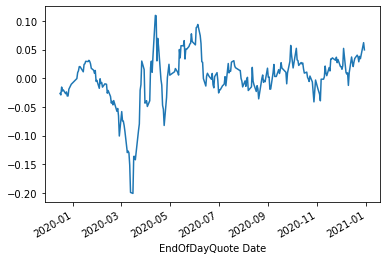

In [ ]:
df_per_instruments.iloc[:, 0].pct_change(20).plot()

週次リターンを求めます。値が存在しないデータは0で補完します。

In [ ]:
df_return = df_per_instruments.pct_change(7).fillna(0)

In [ ]:
df_return

Local Code,1301,1332,1333,1375,1377,1379,1407,1413,1414,1417,1419,1429,1431,1448,1515,1605,1662,1663,1719,1720,1721,1723,1726,1762,1766,1793,1799,1801,1802,1803,1805,1808,1810,1811,1812,1813,1815,1820,1821,1822,1824,1833,1835,1852,1860,1861,1870,1871,1878,1879,...,9757,9759,9766,9783,9787,9788,9790,9793,9795,9810,9823,9824,9828,9830,9831,9832,9842,9843,9850,9856,9861,9869,9873,9882,9887,9889,9896,9900,9902,9903,9919,9928,9932,9934,9936,9945,9946,9948,9956,9960,9962,9974,9979,9983,9984,9987,9989,9991,9994,9997
EndOfDayQuote Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

マーケットのリターンを求めます。ここでは全銘柄のリターンの中央値をマーケットのリターンとします。

In [ ]:
# universe
df_universe = df_return.median(axis=1)

各銘柄のリターンからマーケットのリターンを引いた、マーケット調整済みリターンを求めます。

In [ ]:
df_return_mka = df_return.apply(lambda x: x - df_universe)

In [ ]:
df_return_mka

Local Code,1301,1332,1333,1375,1377,1379,1407,1413,1414,1417,1419,1429,1431,1448,1515,1605,1662,1663,1719,1720,1721,1723,1726,1762,1766,1793,1799,1801,1802,1803,1805,1808,1810,1811,1812,1813,1815,1820,1821,1822,1824,1833,1835,1852,1860,1861,1870,1871,1878,1879,...,9757,9759,9766,9783,9787,9788,9790,9793,9795,9810,9823,9824,9828,9830,9831,9832,9842,9843,9850,9856,9861,9869,9873,9882,9887,9889,9896,9900,9902,9903,9919,9928,9932,9934,9936,9945,9946,9948,9956,9960,9962,9974,9979,9983,9984,9987,9989,9991,9994,9997
EndOfDayQuote Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

無限大は扱いにくいので nan に置換します

In [ ]:
df_return_mka.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
pd.merge(
    df_return_mka.mean().sort_values(ascending=False).to_frame(),
    df_stock_list.set_index('Local Code')['Name (English)'],
    right_index=True,
    left_index=True,
    how='left'
)

,0,Name (English)
Local Code,,
4308,0.073761,J-Stream Inc.
3998,0.068195,"SuRaLa Net Co.,Ltd."
4477,0.063713,"BASE,Inc."
3962,0.060369,CHANGE Inc.
2150,0.059645,"CareNet,Inc."
...,...,...
6824,-0.206897,"NEW COSMOS ELECTRIC CO.,LTD."
4365,-0.209657,"MATSUMOTO YUSHI-SEIYAKU CO.,LTD."
4781,-0.217456,"NIHON HOUSING CO.,LTD."


データの存在する全区間で運用益の平均が高い順に銘柄の情報を表示します

In [ ]:
# 平均運用益の高い銘柄をリストアップ
pd.merge(
    df_return.replace([np.inf, -np.inf], np.nan).mean().sort_values(ascending=False).to_frame(),
    df_stock_list.set_index('Local Code')[['Name (English)', '33 Sector(name)']],
    right_index=True,
    left_index=True,
    how='left'
).head(20)

,0,Name (English),33 Sector(name)
Local Code,,,
4308,0.072177,J-Stream Inc.,Information & Communication
3998,0.066611,"SuRaLa Net Co.,Ltd.",Information & Communication
4477,0.062128,"BASE,Inc.",Information & Communication
3962,0.058785,CHANGE Inc.,Information & Communication
2150,0.058061,"CareNet,Inc.",Services
3681,0.055863,"V-cube,Inc.",Information & Communication
4488,0.053805,AI inside Inc.,Information & Communication
4475,0.052166,HENNGE K.K.,Information & Communication
2929,0.051808,"Pharma Foods International Co.,Ltd.",Foods


2020年3月のデータはコロナ禍による影響が含まれていると考えられるため、全区間で平均を計算すると、直近の状況を正しく反映していない可能性があります。コロナ禍の影響が落ち着いてきた4月以降のデータのみでフィルタリングします。

In [ ]:
# 2020年 4 月以降に限定
filter_date = df_return_mka.index.to_series().between('2020-04-01', '2021-01-01')

In [ ]:
# 2020 年 3 月以降の運用益の平均値が高い銘柄をリストアップ
pd.merge(
    df_return[filter_date].replace([np.inf, -np.inf], np.nan).mean().sort_values(ascending=False).to_frame(),
    df_stock_list.set_index('Local Code')[['Name (English)', '33 Sector(name)']],
    right_index=True,
    left_index=True,
    how='left'
).head(20)

,0,Name (English),33 Sector(name)
Local Code,,,
4477,0.102239,"BASE,Inc.",Information & Communication
2150,0.094129,"CareNet,Inc.",Services
3998,0.088449,"SuRaLa Net Co.,Ltd.",Information & Communication
6095,0.079374,"MedPeer,Inc.",Services
6070,0.079013,"CAREERLINK CO.,LTD.",Services
3788,0.078420,GMO GlobalSign Holdings K.K.,Information & Communication
3663,0.077006,ArtSpark Holdings Inc.,Information & Communication
3962,0.074145,CHANGE Inc.,Information & Communication
4308,0.073516,J-Stream Inc.,Information & Communication


コンペの課題では、月曜日に買って金曜日に売るという売り買いの仕方が決まっているので、金曜日のデータに限定します。
チュートリアルでも触れているように、機関投資家が金曜日にまとめて売却する、といった運用をするなど、曜日に特徴的な影響がある可能性があります。
ここではその影響を見ます。

In [ ]:
# 2020年 4 月以降に限定
filter_date = df_return_mka.index.to_series().between('2020-04-01', '2021-01-01')
filter_day_of_week = df_return_mka.index.dayofweek == 4 # 金曜日

In [ ]:
# 金曜日に売却したときの平均運用益が高いものをリストアップ
pd.merge(
    df_return[filter_date & filter_day_of_week].replace([np.inf, -np.inf], np.nan).mean().sort_values(ascending=False).to_frame(),
    df_stock_list.set_index('Local Code')[['Name (English)', '33 Sector(name)']],
    right_index=True,
    left_index=True,
    how='left'
).head(20)

,0,Name (English),33 Sector(name)
Local Code,,,
4477,0.100712,"BASE,Inc.",Information & Communication
2150,0.098484,"CareNet,Inc.",Services
6095,0.097915,"MedPeer,Inc.",Services
3998,0.085084,"SuRaLa Net Co.,Ltd.",Information & Communication
2484,0.084841,"DEMAE-CAN CO.,LTD",Information & Communication
4308,0.083967,J-Stream Inc.,Information & Communication
7707,0.080725,"Precision System Science Co.,Ltd.",Precision Instruments
2158,0.080411,"FRONTEO,Inc.",Services
3962,0.080328,CHANGE Inc.,Information & Communication


時間方向に平均をとった、2020年4月以降の各銘柄の未調整のリターンの分布です。金曜日のリターンは曜日で均したリターンより若干小さい傾向があります。

Text(0.5, 1.0, 'distribution of weekly return')

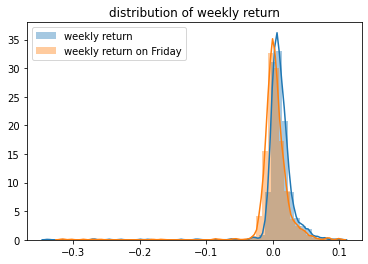

In [ ]:
sns.distplot(df_return[filter_date].replace([np.inf, -np.inf], np.nan).mean(), label='weekly return')
sns.distplot(df_return[filter_date & filter_day_of_week].replace([np.inf, -np.inf], np.nan).mean(), label='weekly return on Friday')
plt.legend()
plt.title('distribution of weekly return')

マーケット調整済みリターンについても同様の可視化をします。こちらは金曜日と曜日全般でほとんど違いが見られません。

Text(0.5, 1.0, 'distribution of weekly market-adjusted return')

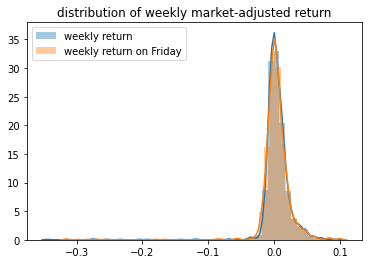

In [ ]:
sns.distplot(df_return_mka[filter_date].replace([np.inf, -np.inf], np.nan).mean(), label='weekly return')
sns.distplot(df_return_mka[filter_date & filter_day_of_week].replace([np.inf, -np.inf], np.nan).mean(), label='weekly return on Friday')
plt.legend()
plt.title('distribution of weekly market-adjusted return')

今度は、マーケットのリターン（銘柄の平均）について同様の可視化をします。若干金曜日のリターンの分布のほうが左側に裾野が長い傾向が見られます。

Text(0.5, 1.0, 'distribution of weekly market return')

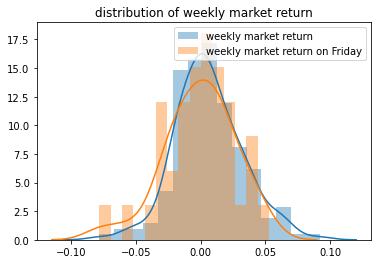

In [ ]:
sns.distplot(df_universe[filter_date].replace([np.inf, -np.inf], np.nan), bins=15, label='weekly market return')
sns.distplot(df_universe[filter_date & filter_day_of_week].replace([np.inf, -np.inf], np.nan), bins=15, label='weekly market return on Friday')
plt.legend()
plt.title('distribution of weekly market return')

リターンが大きい銘柄は、ボラティリティ（標準偏差）も大きい傾向にあります。
ポートフォリオを組むさいは、ボラが大きすぎる銘柄はリスクも大きいので、この値も重要となります。
平均値をボラティリティで割った値（ここではこの値をsharpe ratioと定義します）も求めます。

In [ ]:
# 金曜日に売却したときの平均運用益が高いものをリストアップ
df_ = pd.concat([
    df_return[filter_date & filter_day_of_week].replace([np.inf, -np.inf], np.nan).mean(),
    df_return[filter_date & filter_day_of_week].replace([np.inf, -np.inf], np.nan).std(),
    df_return_mka[filter_date & filter_day_of_week].replace([np.inf, -np.inf], np.nan).mean(),
    df_return_mka[filter_date & filter_day_of_week].replace([np.inf, -np.inf], np.nan).std(),
], axis=1)
df_.columns = ['return_7_mean', 'return_7_std', 'mka_return_7_mean', 'mka_return_7_std']
df_['SHARPE'] = df_['mka_return_7_mean'] / df_['mka_return_7_std']

In [ ]:
df_.sort_values('mka_return_7_mean', ascending=False, inplace=True)

In [ ]:
# 金曜日に売却したときの平均運用益が高いものをリストアップ
pd.merge(
    df_.replace([np.inf, -np.inf], np.nan).sort_values('return_7_mean', ascending=False),
    df_stock_list.set_index('Local Code')[['Name (English)', '33 Sector(name)']],
    right_index=True,
    left_index=True,
    how='left'
).head(20)

,return_7_mean,return_7_std,mka_return_7_mean,mka_return_7_std,SHARPE,Name (English),33 Sector(name)
Local Code,,,,,,,
4477,0.100712,0.198377,0.101338,0.199323,0.508412,"BASE,Inc.",Information & Communication
2150,0.098484,0.184599,0.099110,0.185575,0.534070,"CareNet,Inc.",Services
6095,0.097915,0.175031,0.098541,0.175797,0.560540,"MedPeer,Inc.",Services
3998,0.085084,0.185969,0.085711,0.194234,0.441274,"SuRaLa Net Co.,Ltd.",Information & Communication
2484,0.084841,0.141081,0.085468,0.145884,0.585862,"DEMAE-CAN CO.,LTD",Information & Communication
4308,0.083967,0.150412,0.084594,0.154656,0.546979,J-Stream Inc.,Information & Communication
7707,0.080725,0.252090,0.081352,0.245396,0.331512,"Precision System Science Co.,Ltd.",Precision Instruments
2158,0.080411,0.233891,0.081037,0.221711,0.365507,"FRONTEO,Inc.",Services
3962,0.080328,0.159603,0.080954,0.149936,0.539925,CHANGE Inc.,Information & Communication


いくつか銘柄をピックアップして分布を可視化します。

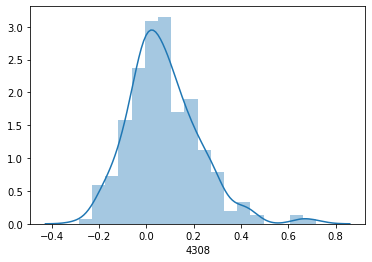

In [ ]:
sns.distplot(df_return_mka.loc[:, 4308])

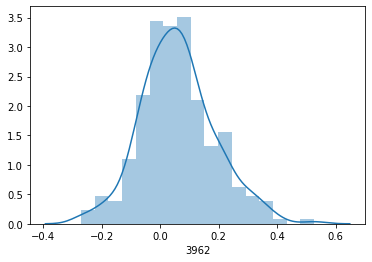

In [ ]:
sns.distplot(df_return_mka.loc[:, 3962].replace([np.inf, -np.inf], 0))

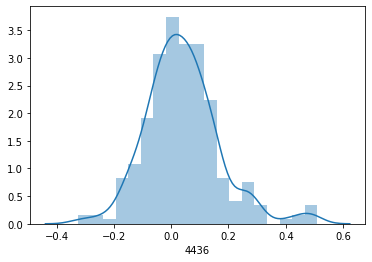

In [ ]:
sns.distplot(df_return_mka.loc[:, 4436].replace([np.inf, -np.inf], 0))

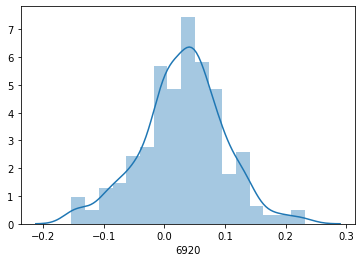

In [ ]:
sns.distplot(df_return_mka.loc[:, 6920].replace([np.inf, -np.inf], 0))

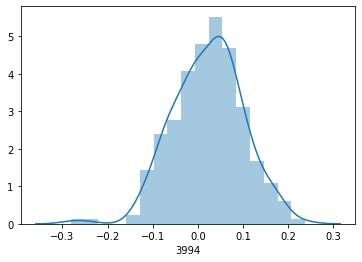

In [ ]:
sns.distplot(df_return_mka.loc[:, 3994].replace([np.inf, -np.inf], 0))

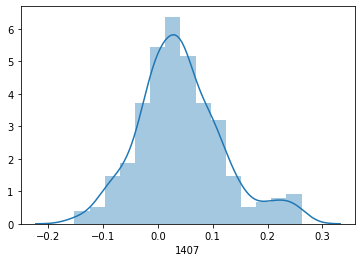

In [ ]:
sns.distplot(df_return_mka.loc[:, 1407].replace([np.inf, -np.inf], 0))

以上からわかることは、

* 運用益の高い銘柄に着目すると、全区間の運用益の平均値よりもコロナ禍が落ち着いてきたと思われる2020年4月以降の運用益の平均値のほうが大きく、コロナ禍の前後で市場の状態が変化している可能性がる。
* 2020年4月以降の週次リターンに着目すると、金曜日のマーケットのリターンは曜日全体のリターンより若干小さい。
* 2020年4月以降の週次リターンに着目すると、最もパフォーマンスの良い銘柄のみを選択したとしても、1週間で得られるリターンの期待値は高々 10% 程度。

次にやること
* 2021年の最新のデータで市場の状態に変化があるかを調べる。
* 週次リターンなどの株価の特徴から、将来のリターンの期待値を予測できるかどうかを検証する
  - 時系列モデルによるあてはめが有効かどうかを検証する